# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torch.utils.data import Dataset, DataLoader, random_split

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [28]:
# Define transforms
transform = transforms.Compose([transforms.RandomVerticalFlip(0.5), #flip image vertically with p(.5)
                              transforms.ToTensor(), #convert image to tensor for model
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #normalize mean and sd

#num of subprocesses
workers=2
#samples per batch
batch=32

# Create training set and define training dataloader
trainingset = torchvision.datasets.CIFAR10(root='data', train=True, transform=transform, download=True)

#split trainingset into training and validation sets
trainset, valset = torch.utils.data.random_split(trainingset, [int(len(trainingset)*.8), int(len(trainingset)*.2)])
trainload = torch.utils.data.DataLoader(trainset, batch_size=batch, num_workers=workers, shuffle=True)
valload = torch.utils.data.DataLoader(valset, batch_size=batch, num_workers=workers, shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='data', train=False, transform=transforms.ToTensor(), download=True)
testload = torch.utils.data.DataLoader(testset, batch_size=batch, num_workers=workers, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [11]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.figure(figsize=(3,3))
        plt.imshow(image.T)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


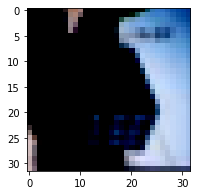

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


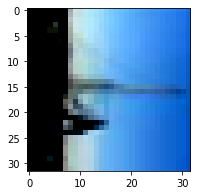

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


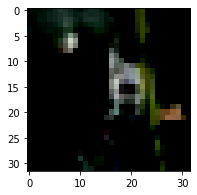

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


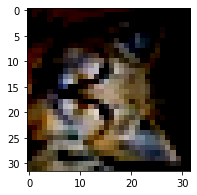

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


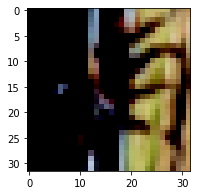

In [30]:
# Explore data
show5(trainload);

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [18]:
## YOUR CODE HERE ##
import torch
from torch import nn
from torch.nn import functional as F

#NN architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        #3 Convo layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        #2 Pooling layers
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        #3 Fully connected layers
        self.fc1 = nn.Linear(128*8*8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
        #3 Dropout layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.25)
        
        # Softmax layer
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        
        #input through layers
        x = F.relu(self.conv1(x)) #understand patterns/specific features
        x = self.pool1(x)
        x = F.relu(self.conv2(x)) #understand patterns/specific features
        x = self.pool2(x)
        x = F.relu(self.conv3(x)) #understand patterns/specific features
        
        #flatten output
        x = x.view(-1, 128*8*8)   
        
        #pass through connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) #avoid overfitting
        x = F.relu(self.fc2(x))
        x = self.dropout2(x) #avoid overfitting
        
        logits = self.fc3(x)
        x = self.log_softmax(logits)
        
        return x

#create nn
network = NeuralNetwork()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [19]:
## YOUR CODE HERE ##
from torch.optim import Adam

#loss function - minimizes loss for high probability selections
#crit = nn.NLLLoss()
crit = nn.CrossEntropyLoss()
optimizer = Adam(network.parameters(), lr = 0.0001)
#optimizer = optim.SGD(network.parameters(), lr=0.0001, momentum=0.9)

In [35]:
print(torch.cuda.is_available())

False


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [20]:
def test(network, valload):
    val_loss = 0
    val_correct = 0
    
    #extract each image/label from testload, run through neural network for predictions
    for data in valload:
        images, labels = data
        images, labels = Variable(images), Variable(labels)
        outputs = network(images)
        
        #calc validation loss and accuracy of predictions
        val_loss += crit(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        
        #count of correct predictions
        if predicted[0] == labels[0]:
            val_correct += 1
        
    val_loss /= len(valload)
    val_acc = 100 * val_correct / len(valload)
    #pred_class = classes[outputs.argmax()]
    
    return val_loss, val_acc#, pred_class

def train(network, trainload):
    train_loss = 0
    train_correct = 0
    
    #extract each image/label from train_loader, run through neural network for predictions
    for data in trainload:
        images, labels = data
        images, labels = Variable(images), Variable(labels)
        
        #claculate gradients of loss function and update weights
        optimizer.zero_grad()
        outputs = network(images)
        loss = crit(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #calc training loss and accuracy of predictions
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        
        #count of correct predictions
        if predicted[0] == labels[0]:
            train_correct += 1
            
    train_loss /= len(trainload)
    train_acc = 100* train_correct / len(trainload)
    
    return train_loss, train_acc

In [22]:
from torch.autograd import Variable

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(30):  # loop over the dataset
        
    #evaluate model by passing each epoch through previously defined functions
    train_loss, train_acc = train(network, trainload)
    train_losses.append(train_loss)
    train_accs.append(train_acc) 
    val_loss, val_acc = test(network, valload)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    #print metrics
    print('Epoch: {} | Train Loss: {:.2f} | Val Loss: {:.2f} | Train Acc: {:.2f} | Val Acc: {:.2f}'.format(
        epoch, train_losses[-1], val_losses[-1], train_accs[-1], val_accs[-1]))
    

Epoch: 0 | Train Loss: 1.74 | Val Loss: 1.62 | Train Acc: 33.92 | Val Acc: 40.58
Epoch: 1 | Train Loss: 1.57 | Val Loss: 1.52 | Train Acc: 40.72 | Val Acc: 43.45
Epoch: 2 | Train Loss: 1.49 | Val Loss: 1.45 | Train Acc: 44.56 | Val Acc: 48.88
Epoch: 3 | Train Loss: 1.42 | Val Loss: 1.38 | Train Acc: 47.68 | Val Acc: 47.60
Epoch: 4 | Train Loss: 1.36 | Val Loss: 1.35 | Train Acc: 48.24 | Val Acc: 48.56
Epoch: 5 | Train Loss: 1.31 | Val Loss: 1.29 | Train Acc: 51.20 | Val Acc: 49.20
Epoch: 6 | Train Loss: 1.26 | Val Loss: 1.25 | Train Acc: 55.20 | Val Acc: 51.12
Epoch: 7 | Train Loss: 1.22 | Val Loss: 1.21 | Train Acc: 58.08 | Val Acc: 54.31
Epoch: 8 | Train Loss: 1.17 | Val Loss: 1.18 | Train Acc: 55.60 | Val Acc: 57.19
Epoch: 9 | Train Loss: 1.13 | Val Loss: 1.14 | Train Acc: 59.84 | Val Acc: 65.81
Epoch: 10 | Train Loss: 1.09 | Val Loss: 1.12 | Train Acc: 60.80 | Val Acc: 60.70
Epoch: 11 | Train Loss: 1.06 | Val Loss: 1.08 | Train Acc: 61.68 | Val Acc: 61.34
Epoch: 12 | Train Loss: 1.

Plot the training loss (and validation loss/accuracy, if recorded).

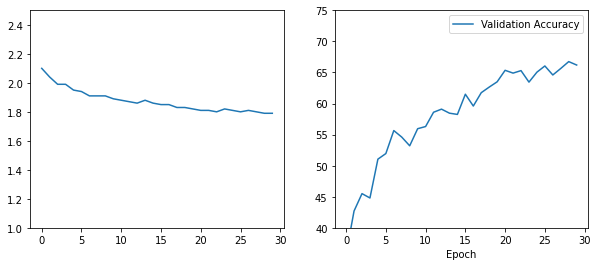

In [25]:
## YOUR CODE HERE ##
import matplotlib.pyplot as plt
import numpy as np

epoch = np.arange(0, 30)
val_loss = [2.1, 2.04, 1.99, 1.99, 1.95, 1.94, 1.91, 1.91, 1.91, 1.89, 1.88, 1.87, 1.86, 1.88, 1.86,
           1.85, 1.85, 1.83, 1.83, 1.82, 1.81, 1.81, 1.8, 1.82, 1.81, 1.8, 1.81, 1.80, 1.79, 1.79]
val_accuracy = [35.75, 42.7, 45.5, 44.8, 51.05, 51.95, 55.65, 54.6, 53.2, 55.95, 56.3, 58.6, 59.1, 58.45, 58.25,
               61.5, 59.6, 61.75, 62.65, 63.5, 65.35, 64.9, 65.3, 63.45, 65.05, 66.05, 64.6, 65.65, 66.75, 66.2]

#set up charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(epoch, val_loss, label='Validation Loss')
ax1.set_ylim([1, 2.5])

ax2.plot(epoch, val_accuracy, label='Validation Accuracy')
ax2.set_ylim([40, 75])
ax2.set_xlabel('Epoch')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

True label: cat


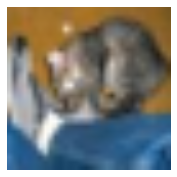

Network prediction: cat
Class probability: 56.39%

True label: ship


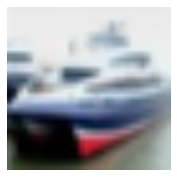

Network prediction: ship
Class probability: 80.78%

True label: ship


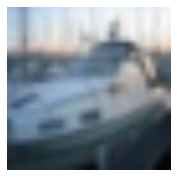

Network prediction: plane
Class probability: 32.82%

True label: plane


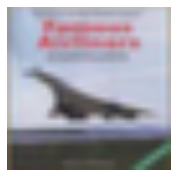

Network prediction: plane
Class probability: 67.90%

True label: frog


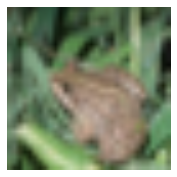

Network prediction: cat
Class probability: 35.47%



In [35]:
dataiter = iter(testload)

batch = next(dataiter)
labels = batch[1][0:5]
images = batch[0][0:5]
predictions = network(images) #run image through neural network
predicted_classes = predictions.argmax(dim=1) #pull in class of top prediction
probabilities = predictions.max(dim=1)[0] #pull in probability of top prediction

for i in range(5):
    print('True label: {}'.format(classes[labels[i]]))
    
    image = images[i].numpy()
    
    plt.figure(figsize=(3,3)) #shrink image
    plt.imshow(image.transpose(1, 2, 0), interpolation='bilinear') #rotate image and make clearer
    plt.axis('off')
    plt.show()
    
    pred_class = classes[predicted_classes[i]]
    log_prob = probabilities[i].item()
    prob = torch.exp(torch.tensor(log_prob))
    print('Network prediction: {}'.format(pred_class))
    print('Class probability: {:.2f}%'.format(prob*100))
    print('')

## Saving your model
Using `torch.save`, save your model for future loading.

In [36]:
import codecs
def save_model(network, path):
    with codecs.open(path, "wb", encoding="utf-8") as f:
        torch.save(network.state_dict(), path)
    
def load_model(path):
    network = NeuralNetwork()
    nework.load_state_dict(torch.load(path))
    return network

In [37]:
## YOUR CODE HERE ##
save_model(network, 'trained_model.pt')
print('Model saved')

Model saved


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

I would recommend buying over building. Although after running 30 epoch's (albeit this took 2.5+ hours to run), I was  able to get up to slightly under 70% accuracy with a continued decrease in validation loss, when I actually tested the model it wasn't able to get many of the images classified correctly. My network confused the image of a car for a plane and the image of a frog for a cat.

While I am confident that with some additional adjustments to the parameters and a higher number of training repetitions that I could improve the model, the sheer amount of time and experimentation required to do so is not worth pursuing short of wanting to learn more and improve my ability to build a strong neural network.

That being said, some adjustments I would make to improve my model are as follows:
- Decrease the learning rate
- Incorporate L2 regularization 
- Increase the number of epochs to at least 100